# ETTJ - Estrutura a Termo da Taxa de Juros

## Arquivos a serem baixados

<https://www.b3.com.br/pt_br/market-data-e-indices/servicos-de-dados/market-data/historico/boletins-diarios/pesquisa-por-pregao/pesquisa-por-pregao/>
- Pricing Report BVBG.086

O referido arquivo apresenta os dados de pregão de todos os ativos negociados na bolsa.
No nosso caso, irá nos interessar somente as entradas dos DIs, que iremos filtrar abaixo.

Inicialmente, o arquivo deve ser baixado manualmente e o seu conteúdo deve ser extraído na pasta 'data'.
Em futuras versões, pretendo fazer um scraping do link acima, para baixar o arquivo automaticamente.

# Pacotes necessários

In [4]:
import pandas as pd
import re
import xml.etree.ElementTree as ET

from datetime import datetime

# Leitura do arquivo Pricing Report BVBG.086

O arquivo zip descompactado tem três arquivos XML. Cada um representa um horário de coleta dos dados pela Bolsa.
Iremos usar o último arquivo, que é ontem tem os dados referentes ao fechamento do dia.

No link abaixo encontra-se a estrutura dos dados do XML
<https://www.b3.com.br/data/files/9F/35/BE/0E/D2E5D6106DB9C4D6DC0D8AA8/Catalogo%20de%20Taxonomia%20UP2DATA%20-%20Portugues.pdf/>

In [5]:
fname = 'data/BVBG.086.01_BV000328202403050328000001945365168.xml'

In [6]:
# namespace do XLM que contém as informações dos ativos
ns = '{urn:bvmf.217.01.xsd}'

In [7]:
# carrega o documento XML
tree = ET.parse(fname)

# Obtém a raiz da árvore
root = tree.getroot()

In [8]:
# Encontrar todos os elementos PricRpt dentro do namespace
# urn:bvmf.217.01.xsd -> namespace do XLM que contém as informações dos ativos
pric_rpt_elements = tree.findall(f'.//{ns}PricRpt')

## Extrai os dados do ativo selecionado

In [9]:
def extrai_dados_ativo(node, ref_date, symbol, ticker_search='^DI1'):
    """
    Busca os elementos do XML referentes às informações do pregão do ativo e verifica
    se o elemento em questão existe. Caso exista, converte para número; senão atribui
    None ao campo.
    
    :param
    df:
    node:
    ref_date:
    symbol:
    ticker_search: 
    :return: Dicionário com os valores de cada campo selecionado do XML.
    """
    
    # Primeiramente, extrai os elementos. Necessário fazer assim para não dar problema
    # caso o  elemento não exista no XML. Se não existir, atribui None à coluna
    
    contratos_abertos_el = node.find(f'{ns}FinInstrmAttrbts/{ns}OpnIntrst')
    num_negocios_el = node.find(f'{ns}FinInstrmAttrbts/{ns}RglrTxsQty')
    contratos_negociados_el = node.find(f'{ns}FinInstrmAttrbts/{ns}FinInstrmQty')
    volume_reais_el = node.find(f'{ns}FinInstrmAttrbts/{ns}NtlFinVol')
    fechamento_el = node.find(f'{ns}FinInstrmAttrbts/{ns}LastPric')
    ajuste_tx_el = node.find(f'{ns}FinInstrmAttrbts/{ns}AdjstdQtTax')
    ajuste_el = node.find(f'{ns}FinInstrmAttrbts/{ns}AdjstdQt')
    abertura_el = node.find(f'{ns}FinInstrmAttrbts/{ns}FrstPric')
    minimo_el = node.find(f'{ns}FinInstrmAttrbts/{ns}MinPric')
    maximo_el = node.find(f'{ns}FinInstrmAttrbts/{ns}MaxPric')
    medio_el = node.find(f'{ns}FinInstrmAttrbts/{ns}TradAvrgPric')
    
    data = {
        'ref_date': ref_date,
        'ticker': symbol,
        'contratos_abertos': float(contratos_abertos_el.text) if contratos_abertos_el is not None else None,
        'num_negocios': float(num_negocios_el.text) if num_negocios_el is not None else None,
        'contratos_negociados': float(contratos_negociados_el.text) if contratos_negociados_el is not None else None,        
        'volume_reais': float(volume_reais_el.text) if volume_reais_el is not None else None,
        'fechamento': float(fechamento_el.text) if fechamento_el is not None else None,
        'ajuste_tx': float(ajuste_tx_el.text) if ajuste_tx_el is not None else None,
        'ajuste': float(ajuste_el.text) if ajuste_el is not None else None,
        'abertura': float(abertura_el.text) if abertura_el is not None else None,
        'minimo': float(minimo_el.text) if minimo_el is not None else None,
        'maximo': float(maximo_el.text) if maximo_el is not None else None,
        'medio': float(medio_el.text) if medio_el is not None else None,
    }
    
    return data

## Organiza os dados extraidos em um dataframe

In [10]:
# cols = [ 'ref_date', 'ticker', 'contratos_abertos','num_negocios','contratos_negociados', 'volume_reais','fechamento','ajuste_tx','ajuste','abertura','minimo','maximo','medio']
# df = pd.DataFrame(columns=cols)
def filtra_contratos():
    """
    
    :return: Dataframe com os dados do ativo selecionado 
    """
    
    data = []
    
    # Percorrer todos os elementos PricRpt
    for pric_rpt in pric_rpt_elements:    
        trad_dt = pric_rpt.find(f'{ns}TradDt/{ns}Dt').text # data da operação    
        tckr_symb = pric_rpt.find(f'{ns}SctyId/{ns}TckrSymb').text # ticker do ativo
    
        #if "DI1" in tckr_symb:
        if re.search(r'^DI1', tckr_symb) :         
            data.append(extrai_dados_ativo(pric_rpt, trad_dt, tckr_symb))            
            #print(f"Data de Negociação: {trad_dt}, Símbolo: {tckr_symb}")
    
    df = pd.DataFrame(data)
    return df

In [11]:
df = filtra_contratos()

In [12]:
df

,ref_date,ticker,contratos_abertos,num_negocios,contratos_negociados,volume_reais,fechamento,ajuste_tx,ajuste,abertura,minimo,maximo,medio
0,2024-03-05,DI1V24,2623009.0,26706.0,482112.0,4.558175e+10,10.085,10.086,94548.86,10.115,10.080,10.115,10.091
1,2024-03-05,DI1N26,2037090.0,6124.0,51786.0,4.171850e+09,9.780,9.765,80579.87,9.820,9.755,9.825,9.777
2,2024-03-05,DI1H25,12063.0,97.0,39017.0,3.553498e+09,9.800,9.788,91084.64,9.795,9.795,9.810,9.798
3,2024-03-05,DI1X24,111034.0,16.0,233.0,2.184695e+07,10.020,10.007,93768.66,10.035,10.000,10.035,10.015
4,2024-03-05,DI1F34,23943.0,30.0,90.0,3.339828e+06,10.670,10.660,37112.47,10.660,10.650,10.670,10.661
5,2024-03-05,DI1V27,66741.0,147.0,647.0,4.592209e+07,10.090,10.073,71007.69,10.110,10.060,10.125,10.086
6,2024-03-05,DI1N28,33919.0,45.0,422.0,2.771424e+07,10.255,10.235,65708.73,10.265,10.235,10.275,10.248
7,2024-03-05,DI1F27,2095553.0,20340.0,204930.0,1.570959e+10,9.885,9.867,76682.44,9.920,9.855,9.925,9.879
8,2024-03-05,DI1F37,3517.0,NaN,NaN,NaN,NaN,10.710,27295.54,NaN,NaN,NaN,NaN
9,2024-03-05,DI1V26,142179.0,213.0,1307.0,1.026100e+08,9.850,9.831,78544.74,9.880,9.820,9.885,9.850


## Organiza os vencimentos por data

Esta função irá pegar o código de vencimento do ativo e irá colocar a data de vencimento dele

In [13]:
def contract_to_maturity(symbol):
    code = symbol[-3:]
    
    year = int(re.search('\\d\\d$', code).group(0)) + 2000
    
    m_ = { 'F': 1, 'G': 2, 'H': 3, 'J': 4, 'K': 5, 'M': 6, 'N': 7, 'Q': 8, 'U': 9, 'V': 10, 'X': 11, 'Z': 12 }
    month_code = re.search('^.', code).group(0)
    month = str(m_[month_code]).zfill(2)
    #print(symbol, month)
    
    date = f'{year}-{month}-01'
    date = datetime.strptime(date, "%Y-%m-%d")
    
    return date
    

In [14]:
# Aplica no dataframe a função para formatar os vencimentos
df['vencimento'] = df['ticker'].apply(contract_to_maturity)

In [15]:
df = df.sort_values(by='vencimento')

In [16]:
df

,ref_date,ticker,contratos_abertos,num_negocios,contratos_negociados,volume_reais,fechamento,ajuste_tx,ajuste,abertura,minimo,maximo,medio,vencimento
14,2024-03-05,DI1J24,3757399.0,570.0,252935.0,2.510585e+10,10.988,10.986,99258.24,10.990,10.984,10.994,10.988,2024-04-01
27,2024-03-05,DI1K24,594541.0,55.0,64497.0,6.345460e+09,10.808,10.811,98383.75,10.810,10.808,10.816,10.810,2024-05-01
24,2024-03-05,DI1M24,331281.0,9.0,2850.0,2.781122e+08,10.628,10.631,97584.09,10.638,10.628,10.638,10.635,2024-06-01
29,2024-03-05,DI1N24,3215836.0,4608.0,362314.0,3.508841e+10,10.480,10.481,96846.99,10.495,10.475,10.495,10.486,2024-07-01
23,2024-03-05,DI1Q24,182417.0,59.0,3966.0,3.808468e+08,10.315,10.318,96028.45,10.325,10.315,10.350,10.319,2024-08-01
35,2024-03-05,DI1U24,106789.0,5.0,499.0,4.753071e+07,10.195,10.198,95260.56,10.225,10.195,10.225,10.218,2024-09-01
0,2024-03-05,DI1V24,2623009.0,26706.0,482112.0,4.558175e+10,10.085,10.086,94548.86,10.115,10.080,10.115,10.091,2024-10-01
3,2024-03-05,DI1X24,111034.0,16.0,233.0,2.184695e+07,10.020,10.007,93768.66,10.035,10.000,10.035,10.015,2024-11-01
11,2024-03-05,DI1Z24,132640.0,48.0,540.0,5.029245e+07,9.960,9.945,93136.17,9.975,9.940,9.975,9.948,2024-12-01
36,2024-03-05,DI1F25,4543690.0,23797.0,650987.0,6.017676e+10,9.890,9.883,92446.66,9.920,9.875,9.925,9.893,2025-01-01


# Plotando os gráficos da curva de juros

Neste notebook, usarei dois pacotes de visualização do Python.
Primeiro faremos as visualizações utilizando a biblioteca Plotly, que gera belos gráficos interativos.
Num segundo momento, utilizei a biblioteca padrão Matplotlib, a fim de plotar um gráfico no estio FiveThirtyEight estático.

## Plotly

In [17]:
import plotly.graph_objects as go


# Utilizado para definir a saída do gráfico.
# Atribuir "notebook_connected" para gráficos interativos, 
# se for rodar o notebook no computador prório
# Atribuído "svg" para gráfico estático, para que eles sejam 
# plotados no github
import plotly.io as pio
pio.renderers.default = "svg"

Na minha visão, o Python não conta com a simplicidade e eficiência de bibliotecas de visualização como o R apresenta.

O Plotly é uma exelente biblioteca, no entanto, embora seja uma boa biblioteca de visualização, é necessário algumas configurações a mais,
a fim de deixar o gráfico mais polido.

A função abaixo tem esse objetivo, qual seja, formatar os gráficos em termos de dimensão, cores e outras características.

In [18]:
def layout_plotly(title='Curva Pré - DI', xaxis='Vencimento', yaxis='Taxa', width=1000, height=600, template='ggplot2'):
    """
    A função tem como objetivo configurar o layout dos gráficos que são plotados, a fim de evitar redundâncias.
    Qualquer característica que se deseje mudar deve ser inserido aqui nesta função.
    A função recebe como parâmetros as características mais passíveis de alterações na aplicação 
    que estamos desenvolvendo
    
    :param title: Título do gráfico, que irá aparecer no topo da plotagem
    :param xaxis: Título do eixo X
    :param yaxis: Título do eixo Y
    :param width: Largura do gráfico
    :param height: Altura do gráfico
    :param template: Template de estilo a ser utilizada no gráfico
    :return: Retorna um objeto Plotly Layout com todas as características de layout do gráfico 
    """
    layout = go.Layout(
        autosize=False,
        width=width,
        height=height,
        margin=go.layout.Margin(l=50, r=50, b=50, t=50, pad=4),
        xaxis=go.layout.XAxis(linecolor="black", linewidth=1, mirror=True),
        yaxis=go.layout.YAxis(linecolor="black", linewidth=1, mirror=True),
        title={
            'text':title,
            'x':0.5
        },
        xaxis_title=xaxis,
        yaxis_title=yaxis,
        template=template
    )
    
    return layout

### Utilizando os vencimentos

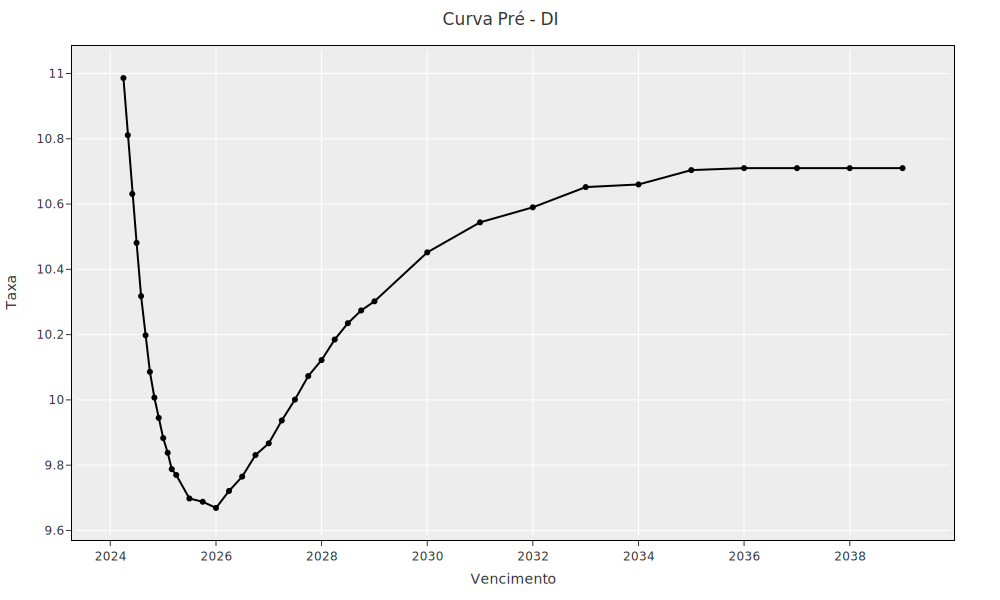

In [19]:
layout = layout_plotly()
fig = go.Figure(layout=layout)

fig.add_trace(go.Scatter(x=df['vencimento'], y=df['ajuste_tx'], mode='lines+markers', name='Taxa', line=dict(color="#000000")))

fig.show()

### Utilizando dias úteis

In [20]:
from bizdays import Calendar

In [21]:
cal = Calendar.load('ANBIMA') # carrega o calendário de dias úteis da ANBIMA
df['DU'] = cal.bizdays(date_from=df['ref_date'], date_to=df['vencimento']) # calcula os diais úteis existentes entre a data de referência e a data de vencimento

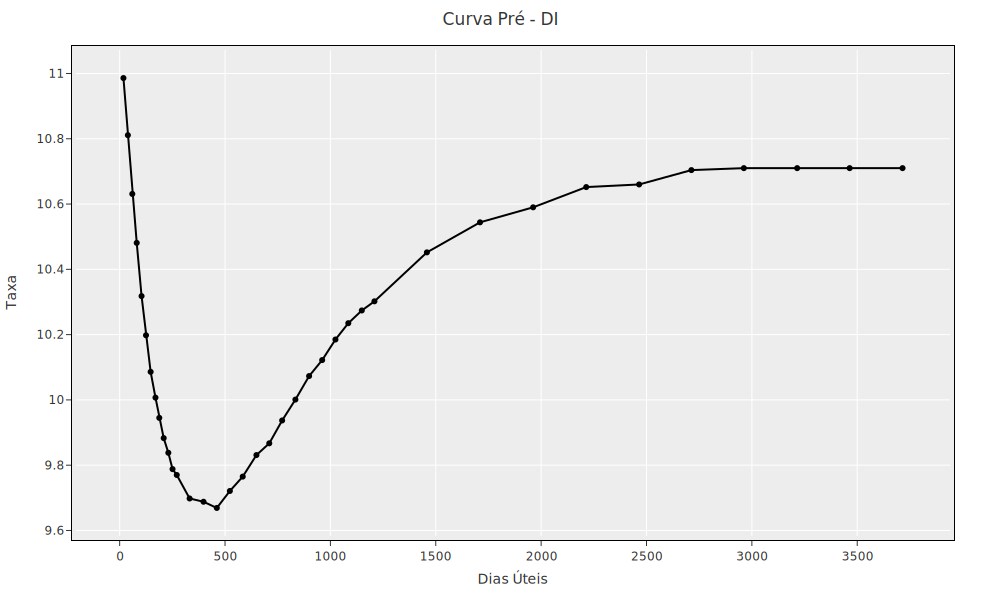

In [23]:
layout = layout_plotly(xaxis='Dias Úteis')
fig = go.Figure(layout=layout)

fig.add_trace(go.Scatter(x=df['DU'], y=df['ajuste_tx'], mode='lines+markers', name='Taxa', line=dict(color="#000000")))

fig.show()

### Utilizando os tickers no eixo X

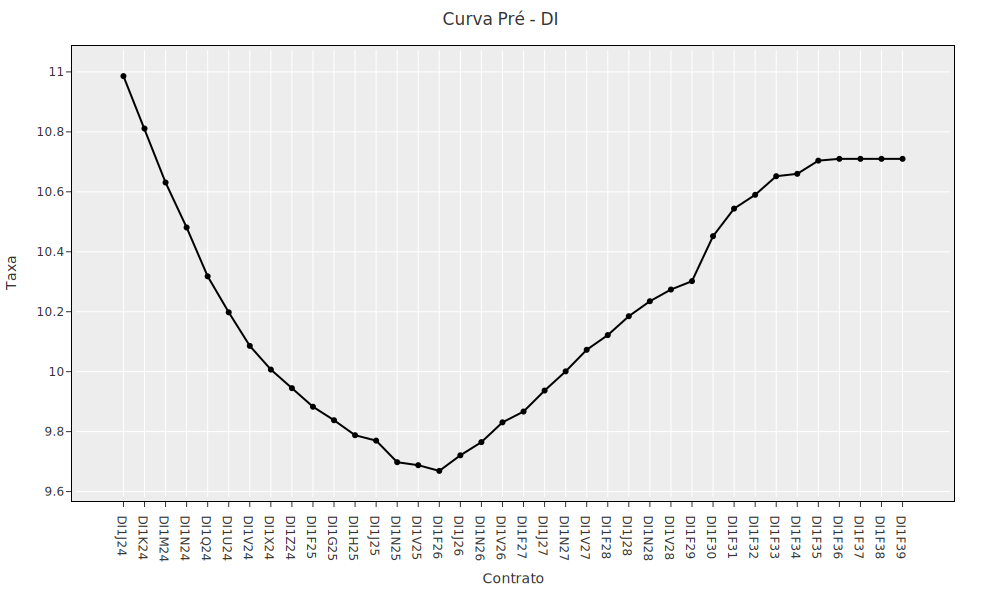

In [24]:
layout = layout_plotly(xaxis='Contrato')
fig = go.Figure(layout=layout)

fig.add_trace(go.Scatter(x=df['ticker'], y=df['ajuste_tx'], mode='lines+markers', name='Taxa', line=dict(color="#000000")))

fig.show()

## Matplotlib

O matplotlib não é uma biblioteca que apresenta visuais tão bonitos quanto a biblioteca ggplot do R.

Contudo, embora muitos não gostem do matplotlib, ela é uma biblioteca bastante versátil. Com um pouco mais de código, é possível
fazer gráficos de apresentação bem bonitos com ela.

In [293]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')

### Utilizando os vencimentos

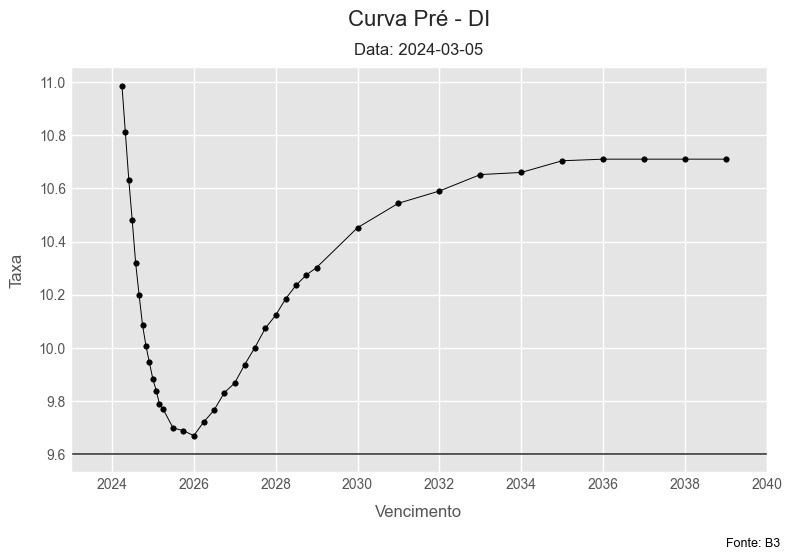

In [302]:
# tamanho da figura
plt.figure(figsize=(8,5))

# Plotar os pontos
plt.scatter(df['vencimento'], df['ajuste_tx'], color='k', label='Dados', s=15)

# Plotar a linha
plt.plot(df['vencimento'], df['ajuste_tx'], color='k', linestyle='-', linewidth=0.7)

# Configurar o título e os rótulos dos eixos
plt.title('Curva Pré - DI', size=16, pad=30., loc='center')
plt.xlabel('Vencimento', size=12, labelpad=10)
plt.ylabel('Taxa', size=12, labelpad=10)

# Adicionar subtítulo e fonte
plt.suptitle(f'Data: {df["ref_date"].unique()[0]}', x=0.515, y=0.93, fontsize=12)

# Configura o tamanho das letras dos eixos
plt.tick_params(axis = 'both', which = 'major', labelsize = 10)

# plota uma linha mais forte na base do gráfico
#base = df['ajuste_tx'].min() - 0.005
plt.axhline(y = 9.6, color = 'black', linewidth = 1.3, alpha = .7)

# Converter os limites do eixo x para datetime
xmin = pd.to_datetime('2023-01-01')
xmax = pd.to_datetime('2040-01-01')

# Configurar os limites do eixo x
plt.xlim(left=xmin, right=xmax)

# Barra de assinatura
x_ = pd.to_datetime('2039-01-01')
plt.text(x = x_, y = 9.25,
    s = 'Fonte: B3', fontsize = 9, color = '#000000')

# Exibir o gráfico
plt.show()

### Utilizando dias úteis

### Utilizando os tickers no eixo X

---

# Taxas Referenciais

<https://www.b3.com.br/pt_br/market-data-e-indices/servicos-de-dados/market-data/consultas/mercado-de-derivativos/precos-referenciais/taxas-referenciais-bm-fbovespa/>

## Webscraping das taxas na B3